### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = 'sample2A.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

[ WARN:0@7.775] global loadsave.cpp:268 findDecoder imread_('sample2A.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
print(centroids)

[[0 2]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 0]
 [0 0]]


 ## Extract Droplet Centroids

[[28, 7], [65, 0], [90, 17], [117, 4], [147, 11], [176, 2], [211, 4], [241, 11], [273, 1], [326, 13], [299, 16], [2, 17], [190, 10], [195, 16], [269, 25], [58, 28], [176, 28], [122, 32], [212, 33], [22, 39], [318, 43], [247, 43], [90, 48], [152, 48], [296, 40], [278, 52], [56, 59], [186, 63], [123, 65], [225, 66], [304, 69], [328, 70], [22, 73], [255, 70], [92, 79], [154, 83], [279, 86], [57, 90], [0, 85], [208, 92], [123, 97], [244, 98], [316, 100], [21, 104], [180, 104], [90, 110], [150, 115], [277, 116], [57, 123], [213, 125], [0, 120], [120, 130], [329, 127], [176, 134], [306, 134], [248, 132], [21, 140], [87, 143], [273, 146], [145, 151], [54, 155], [0, 152], [201, 159], [237, 161], [326, 152], [115, 166], [303, 170], [171, 167], [79, 176], [267, 177], [6, 178], [38, 183], [329, 178], [144, 188], [214, 191], [180, 193], [246, 196], [106, 200], [316, 206], [280, 207], [13, 207], [65, 211], [133, 222], [172, 222], [214, 232], [252, 226], [98, 234], [31, 235], [2, 233], [288, 253], [

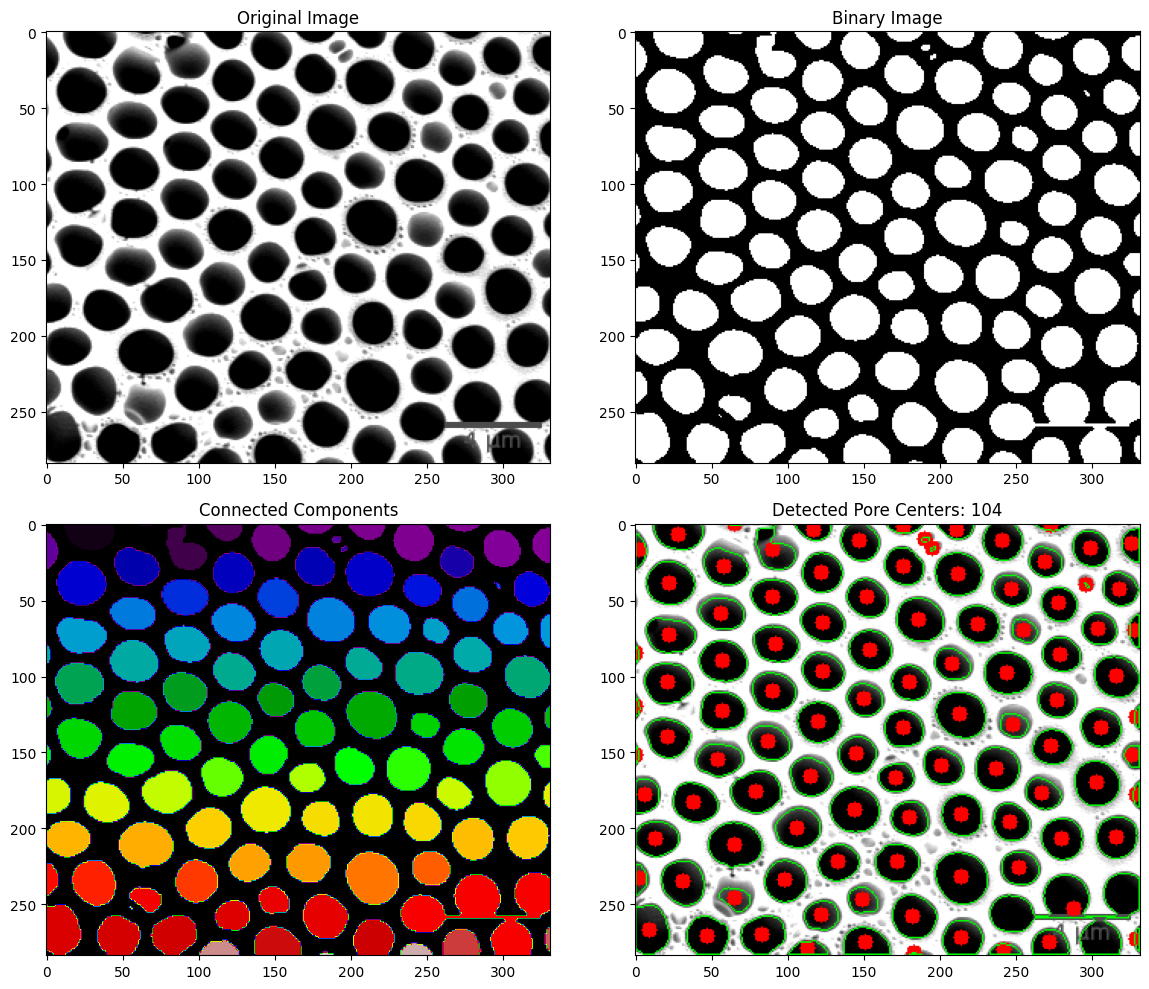

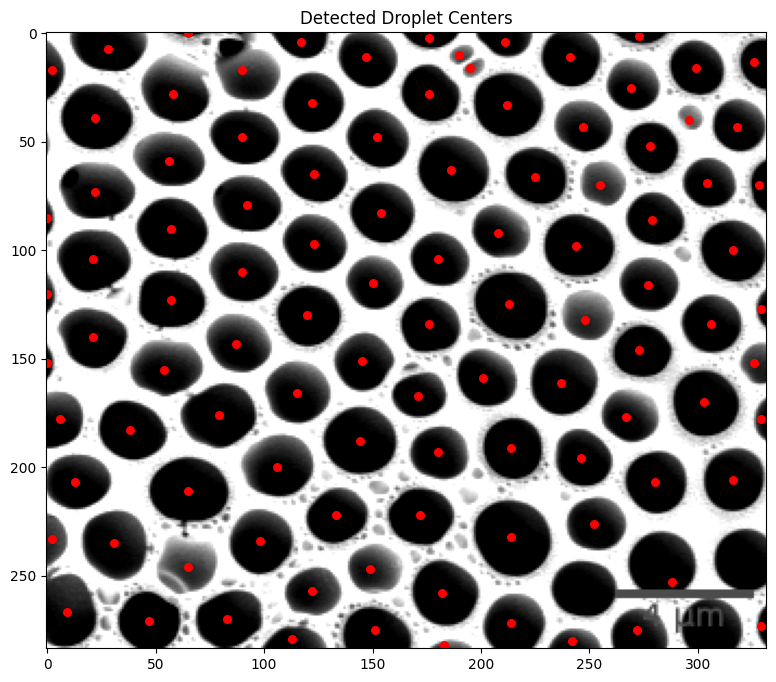

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample5A.png"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply binary threshold - simpler approach that works better for this image
# The black pores are already dark, so use a direct threshold
_, binary = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV)

# Find connected components (black regions)
nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# Filter components by size
min_size = 5 # Minimum area to consider
max_size = 100000  # Maximum area to consider (to filter out background)

# Create output image for visualization
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Filter components and draw their centers
filtered_centroids = []
for i in range(1, nb_components):  # Skip first component (background)
    area = stats[i, cv2.CC_STAT_AREA]
    if min_size < area < max_size:
        # Get center coordinates
        cx = int(centroids[i, 0])
        cy = int(centroids[i, 1])
        
        # Calculate average intensity in the original image for this component
        component_mask = (labels == i).astype(np.uint8)
        mean_intensity = cv2.mean(image, mask=component_mask)[0]
        
        # Only keep dark components (pores are dark)
        if mean_intensity < 100:  # Adjust this threshold as needed
            filtered_centroids.append([cx, cy])
            
            # Draw a red dot at the center
            cv2.circle(output_image, (cx, cy), 5, (0, 0, 255), -1)
            
            # Optional: Draw the component boundary for visualization
            contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(output_image, contours, -1, (0, 255, 0), 1)

# Convert to NumPy array
print(filtered_centroids)
filtered_centroids = np.array(filtered_centroids)
print(f"Number of pores detected: {len(filtered_centroids)}")

# Display the result
plt.figure(figsize=(12, 10))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Binary image
plt.subplot(2, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')

# Labeled components (color-coded)
plt.subplot(2, 2, 3)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Connected Components')

# Final result with centers
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Pore Centers: {len(filtered_centroids)}')

plt.tight_layout()
plt.savefig('improved_pore_detection.png', dpi=300)
plt.show()

# Save the results
np.save('pore_centroids.npy', filtered_centroids)
cv2.imwrite('pore_centers.png', output_image)

# Also create a simple visualization showing just the original image with centers
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.scatter(filtered_centroids[:, 0], filtered_centroids[:, 1], c='red', s=30)
plt.title('Detected Droplet Centers')
plt.savefig('droplet_centers.png', dpi=300)
plt.show()

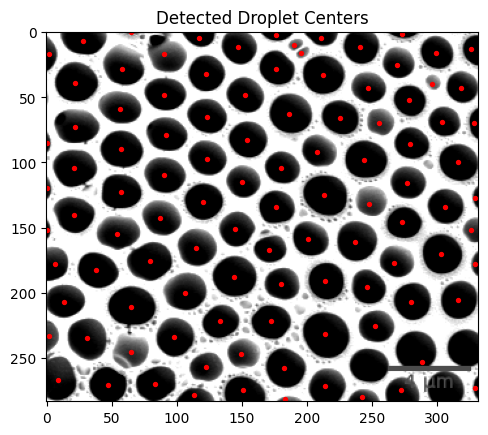

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample5A.png"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply median blur to reduce noise
blurred = cv2.medianBlur(image, 5)

# Use Otsu's thresholding to create a binary mask
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological closing to fill small gaps
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Detect edges using Canny edge detector
edges = cv2.Canny(closed, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert to color image for visualization
output_final = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)


centroids =np.array([[28, 7], [65, 0], [90, 17], [117, 4], [147, 11], [176, 2], [211, 4], [241, 11], [273, 1], [326, 13], [299, 16], [2, 17], [190, 10], [195, 16], [269, 25], [58, 28], [176, 28], [122, 32], [212, 33], [22, 39], [318, 43], [247, 43], [90, 48], [152, 48], [296, 40], [278, 52], [56, 59], [186, 63], [123, 65], [225, 66], [304, 69], [328, 70], [22, 73], [255, 70], [92, 79], [154, 83], [279, 86], [57, 90], [0, 85], [208, 92], [123, 97], [244, 98], [316, 100], [21, 104], [180, 104], [90, 110], [150, 115], [277, 116], [57, 123], [213, 125], [0, 120], [120, 130], [329, 127], [176, 134], [306, 134], [248, 132], [21, 140], [87, 143], [273, 146], [145, 151], [54, 155], [0, 152], [201, 159], [237, 161], [326, 152], [115, 166], [303, 170], [171, 167], [79, 176], [267, 177], [6, 178], [38, 183], [329, 178], [144, 188], [214, 191], [180, 193], [246, 196], [106, 200], [316, 206], [280, 207], [13, 207], [65, 211], [133, 222], [172, 222], [214, 232], [252, 226], [98, 234], [31, 235], [2, 233], [288, 253], [65, 246], [149, 247], [182, 258], [122, 257], [9, 267], [47, 271], [83, 270], [214, 272], [151, 275], [272, 275], [329, 273], [113, 279], [242, 280], [183, 282]]





)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()

## Perform Voronoi Tessellation

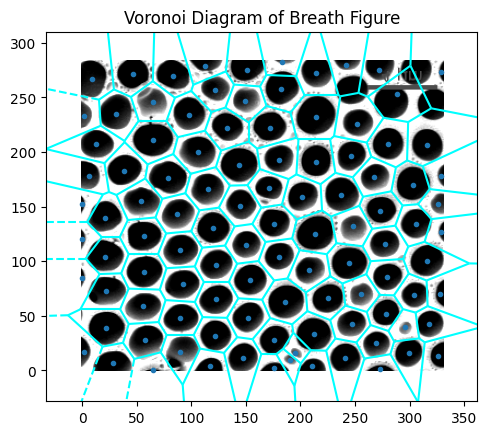

In [44]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


# Beautifying because Science is Beautiful

Data bounds: X: 0 to 329, Y: 0 to 282
Total polygons to be plotted: 87


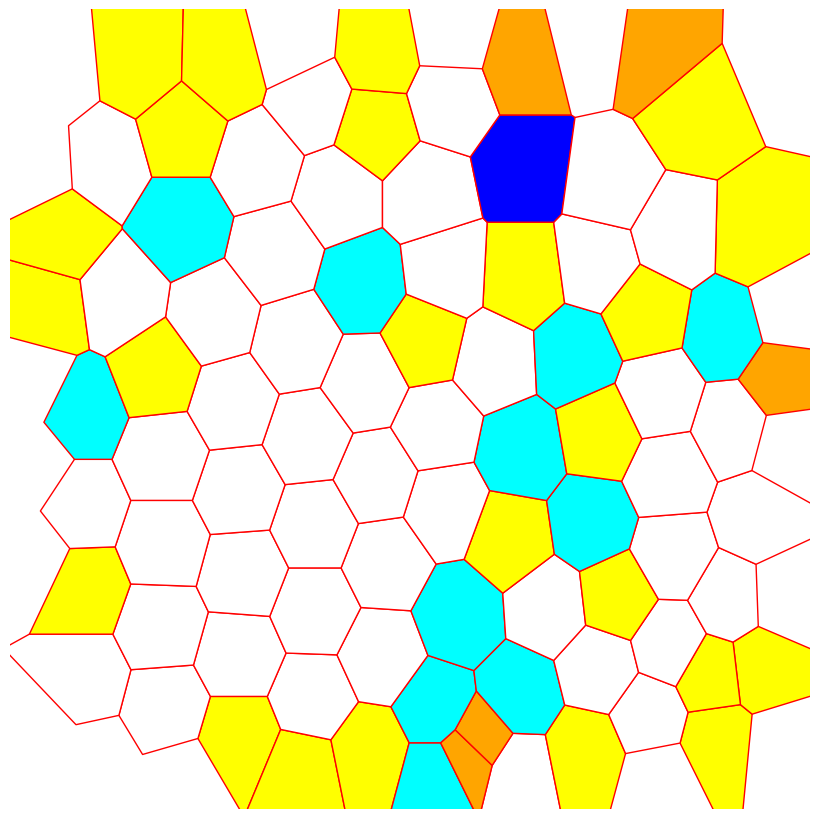

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Your points
points =  np.array([[28, 7], [65, 0], [90, 17], [117, 4], [147, 11], [176, 2], [211, 4], [241, 11], [273, 1], [326, 13], [299, 16], [2, 17], [190, 10], [195, 16], [269, 25], [58, 28], [176, 28], [122, 32], [212, 33], [22, 39], [318, 43], [247, 43], [90, 48], [152, 48], [296, 40], [278, 52], [56, 59], [186, 63], [123, 65], [225, 66], [304, 69], [328, 70], [22, 73], [255, 70], [92, 79], [154, 83], [279, 86], [57, 90], [0, 85], [208, 92], [123, 97], [244, 98], [316, 100], [21, 104], [180, 104], [90, 110], [150, 115], [277, 116], [57, 123], [213, 125], [0, 120], [120, 130], [329, 127], [176, 134], [306, 134], [248, 132], [21, 140], [87, 143], [273, 146], [145, 151], [54, 155], [0, 152], [201, 159], [237, 161], [326, 152], [115, 166], [303, 170], [171, 167], [79, 176], [267, 177], [6, 178], [38, 183], [329, 178], [144, 188], [214, 191], [180, 193], [246, 196], [106, 200], [316, 206], [280, 207], [13, 207], [65, 211], [133, 222], [172, 222], [214, 232], [252, 226], [98, 234], [31, 235], [2, 233], [288, 253], [65, 246], [149, 247], [182, 258], [122, 257], [9, 267], [47, 271], [83, 270], [214, 272], [151, 275], [272, 275], [329, 273], [113, 279], [242, 280], [183, 282]]









)

# Calculate the actual bounds of your data
x_min, y_min = points.min(axis=0)
x_max, y_max = points.max(axis=0)

print(f"Data bounds: X: {x_min} to {x_max}, Y: {y_min} to {y_max}")

# Add buffer to bounds for better visualization
buffer = 10
x_range = [x_min - buffer, x_max + buffer]
y_range = [y_min - buffer, y_max + buffer]

# Compute Voronoi Tessellation
vor = Voronoi(points)

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Define colors based on number of sides
color_map = {
    3: 'red',
    4: 'orange',
    5: 'yellow',
    6: 'white',  # Most common in Voronoi are hexagons
    7: 'cyan',
    8: 'blue',
    9: 'magenta',
    10: 'green'  # For polygons with 10 or more sides
}

# Prepare patches and colors for filled regions
patches = []
patch_colors = []

# Process each Voronoi region
for i, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    
    # Skip if region is unbounded (contains -1)
    if -1 in region or len(region) == 0:
        continue
        
    # Get vertices for this region
    polygon = [vor.vertices[v] for v in region]
    
    # Skip regions that are completely outside the bounds
    # Modified to use actual data range instead of hardcoded 0-400
    if all(vertex[0] < x_range[0] or vertex[0] > x_range[1] or 
           vertex[1] < y_range[0] or vertex[1] > y_range[1] 
           for vertex in polygon):
        continue
    
    # Count number of sides (vertices)
    num_sides = len(polygon)
    
    # Create a polygon patch
    patches.append(Polygon(polygon))
    
    # Assign color based on number of sides
    if num_sides >= 10:
        patch_colors.append(color_map[10])  # Group all large polygons
    elif num_sides in color_map:
        patch_colors.append(color_map[num_sides])
    else:
        patch_colors.append('gray')  # Fallback color

# Print how many polygons we're actually plotting
print(f"Total polygons to be plotted: {len(patches)}")
        
# Create a patch collection with specified colors
patch_collection = PatchCollection(patches, alpha=1)
patch_collection.set_facecolor(patch_colors)
patch_collection.set_edgecolor('red')  # Red borders
patch_collection.set_linewidth(1.0)

# Add the patch collection to the plot
ax.add_collection(patch_collection)

ax.set_xlim(x_range)
ax.set_ylim(y_range)

# Remove axes for a clean look
ax.set_axis_off()
# Use a clean background with no padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout(pad=0)

plt.show()

## Analyze Voronoi Cell Shapes

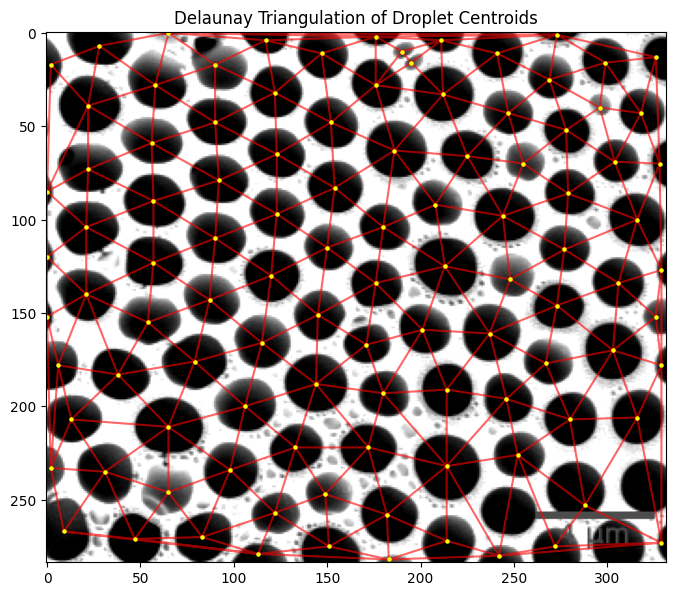

In [46]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


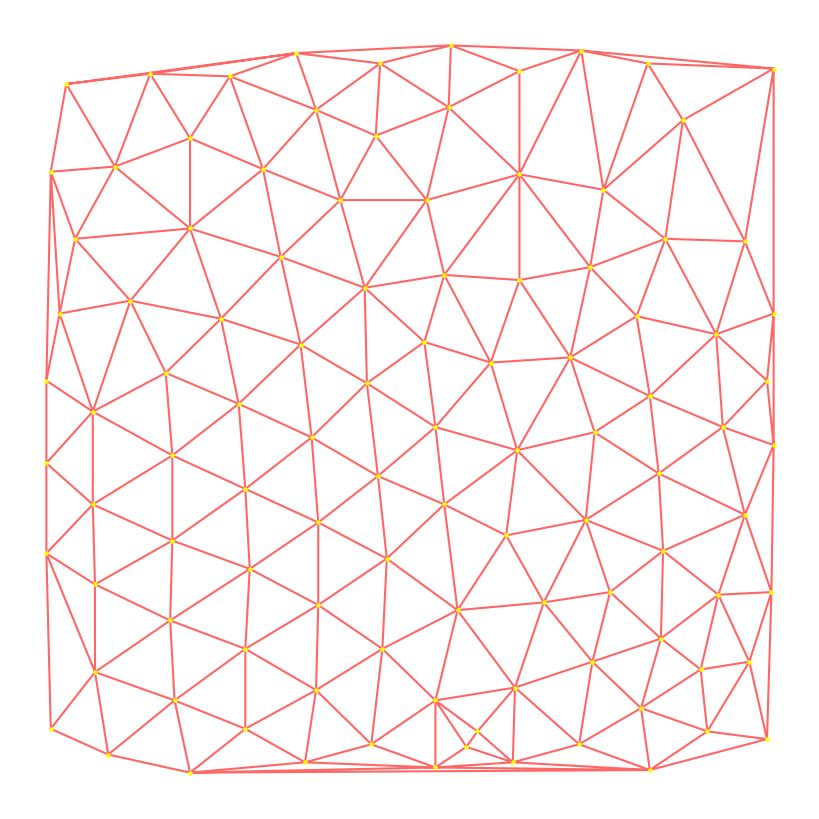

In [47]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

centroids =  np.array([[28, 7], [65, 0], [90, 17], [117, 4], [147, 11], [176, 2], [211, 4], [241, 11], [273, 1], [326, 13], [299, 16], [2, 17], [190, 10], [195, 16], [269, 25], [58, 28], [176, 28], [122, 32], [212, 33], [22, 39], [318, 43], [247, 43], [90, 48], [152, 48], [296, 40], [278, 52], [56, 59], [186, 63], [123, 65], [225, 66], [304, 69], [328, 70], [22, 73], [255, 70], [92, 79], [154, 83], [279, 86], [57, 90], [0, 85], [208, 92], [123, 97], [244, 98], [316, 100], [21, 104], [180, 104], [90, 110], [150, 115], [277, 116], [57, 123], [213, 125], [0, 120], [120, 130], [329, 127], [176, 134], [306, 134], [248, 132], [21, 140], [87, 143], [273, 146], [145, 151], [54, 155], [0, 152], [201, 159], [237, 161], [326, 152], [115, 166], [303, 170], [171, 167], [79, 176], [267, 177], [6, 178], [38, 183], [329, 178], [144, 188], [214, 191], [180, 193], [246, 196], [106, 200], [316, 206], [280, 207], [13, 207], [65, 211], [133, 222], [172, 222], [214, 232], [252, 226], [98, 234], [31, 235], [2, 233], [288, 253], [65, 246], [149, 247], [182, 258], [122, 257], [9, 267], [47, 271], [83, 270], [214, 272], [151, 275], [272, 275], [329, 273], [113, 279], [242, 280], [183, 282]]










)


tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
ax.set_axis_off()

plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout(pad=0)

plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.53


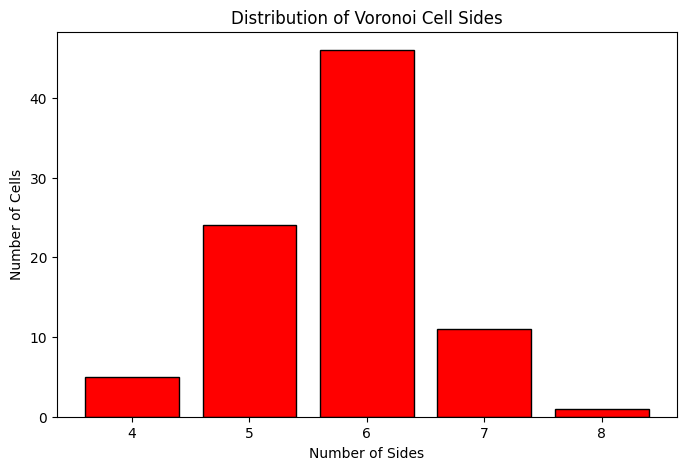

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
vor = Voronoi(centroids)

graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.show()

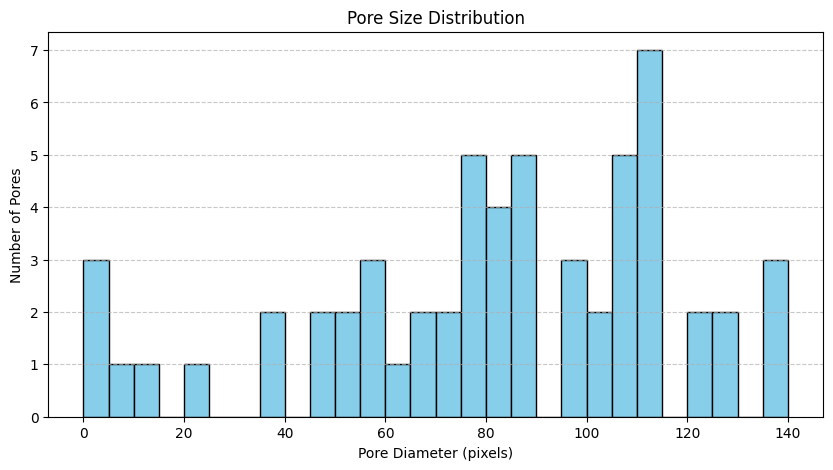

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample2A.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()